# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

### Реализация дерева лежит в [dt.py](https://github.com/alexanderlakiza/cs493/blob/main/labs/dt.py)

In [57]:
from dt import DecisionTreeClassifier
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target
clf = DecisionTreeClassifier()
clf.fit(X, y)

In [60]:
import random
import numpy as np
rands = [random.randint(0, 150) for _ in range(20)]
X_test = np.array([X[i] for i in rands])
y_test = np.array([y[i] for i in rands])
predicted = clf.predict(X_test)

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

1.0

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [75]:
import pandas as pd

In [76]:
df = pd.read_csv('../data/churn.csv')
df = pd.DataFrame(df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1))
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [77]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [78]:
dummies = pd.get_dummies(df[['Geography']])

In [79]:
dummies.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [80]:
out = df.loc[:, ['Age', 'Gender', 'CreditScore', 'Tenure',
           'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
           'EstimatedSalary']]

In [81]:
X = pd.concat([out, dummies], axis=1)

In [82]:
X

,Age,Gender,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,42,0,619,2,0.00,1,1,1,101348.88,1,0,0
1,41,0,608,1,83807.86,1,0,1,112542.58,0,0,1
2,42,0,502,8,159660.80,3,1,0,113931.57,1,0,0
3,39,0,699,1,0.00,2,0,0,93826.63,1,0,0
4,43,0,850,2,125510.82,1,1,1,79084.10,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,39,1,771,5,0.00,2,1,0,96270.64,1,0,0
9996,35,1,516,10,57369.61,1,1,1,101699.77,1,0,0
9997,36,0,709,7,0.00,1,0,1,42085.58,1,0,0
9998,42,1,772,3,75075.31,2,1,0,92888.52,0,1,0


In [83]:
y = df['Exited']

In [84]:
X = X.to_numpy()
y = y.to_numpy()

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=42)

In [86]:
len(X_train)

7000

In [87]:
n_trees = [2, 3, 4]
depths = [4, 5, 6]
min_samples_splits = [20, 40, 60]
bootstraps = [0.5, 0.75, 1]

### Реализация случайного леса лежит в [rf.py](https://github.com/alexanderlakiza/cs493/blob/main/labs/rf.py) и использует мой случайный лес

In [88]:
%%time
from rf import RandomForestClassifier

accuracies = []
n_estimators = []
max_depth = []
bootstrap_size = []
splits = []

counter = 0
for tree in n_trees:
    for depth in depths:
        for split in min_samples_splits:
            for boot in bootstraps:
                print(f"{counter} iteration")

                forest = RandomForestClassifier(n_estimators=tree, max_depth=depth,
                                            min_samples_split=split, bootstrap=boot)
                forest.fit(X_train, y_train)
                predicted = forest.predict(X_test)

                accuracies.append(accuracy_score(y_test, predicted))
                n_estimators.append(tree)
                max_depth.append(depth)
                splits.append(split)
                bootstrap_size.append(boot)

                counter += 1

0 iteration
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration


KeyboardInterrupt: 

После 1.5 часа решил прервать (13 лесов из 81)

In [89]:
accuracies

[0.8053333333333333,
 0.8053333333333333,
 0.8053333333333333,
 0.8053333333333333,
 0.8273333333333334,
 0.8083333333333333,
 0.8116666666666666,
 0.828,
 0.8053333333333333,
 0.826,
 0.8113333333333334,
 0.8053333333333333,
 0.8053333333333333]

In [90]:
stats = pd.DataFrame.from_dict({'n_trees': n_estimators,
                                'max_depth': max_depth,
                                'min_samples_split': splits,
                                'bootstrap': bootstrap_size,
                                'accuracy': accuracies})
stats

,n_trees,max_depth,min_samples_split,bootstrap,accuracy
0,2,4,20,0.50,0.805333
1,2,4,20,0.75,0.805333
2,2,4,20,1.00,0.805333
3,2,4,40,0.50,0.805333
4,2,4,40,0.75,0.827333
5,2,4,40,1.00,0.808333
6,2,4,60,0.50,0.811667
7,2,4,60,0.75,0.828000
8,2,4,60,1.00,0.805333
9,2,5,20,0.50,0.826000


In [96]:
n_trees = [4]
depths = [5]
min_samples_splits = [20, 50, 80]
bootstraps = [1]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                    random_state=13)

In [99]:
%%time
# Попрбуем 3 леса по 4 дерева с разным минимальным кол-вом объектов в листе
from rf import RandomForestClassifier
accuracies = []

n_estimators = []
max_depth = []
bootstrap_size = []
splits = []

counter = 0
for tree in n_trees:
    for depth in depths:
        for split in min_samples_splits:
            for boot in bootstraps:
                print(f"{counter} iteration")

                forest = RandomForestClassifier(n_estimators=tree, max_depth=depth,
                                            min_samples_split=split, bootstrap=boot)
                forest.fit(X_train, y_train)
                predicted = forest.predict(X_test)

                accuracies.append(accuracy_score(y_test, predicted))
                n_estimators.append(tree)
                max_depth.append(depth)
                splits.append(split)
                bootstrap_size.append(boot)

                counter += 1

stats = pd.DataFrame.from_dict({'n_trees': n_estimators,
                                'max_depth': max_depth,
                                'min_samples_split': splits,
                                'bootstrap': bootstrap_size,
                                'accuracy': accuracies})
stats


0 iteration
1 iteration
2 iteration
CPU times: user 1h 52min 23s, sys: 348 ms, total: 1h 52min 24s
Wall time: 1h 52min 29s


,n_trees,max_depth,min_samples_split,bootstrap,accuracy
0,4,5,20,1,0.7975
1,4,5,50,1,0.7975
2,4,5,80,1,0.7975


Как мы видим увеличение обучающей, и кол-ва деревьев до 4-х нам не помогло
Мой алгоритм очень ресурсозатратный. На данные 3 леса ушло почти 2 часа. Из тех лесов, что я построил, наилучший accuracy у леса со следующими характеристиками
- train_size = 0.7
- random_state = 42
- n_estimators = 2
- max_depth = 4
- min_samples_size = 60
- bootstrap_fraction = 0.75

Попробуем применить готовую реализацию леса и посмотреть на его accuracy. Для этого найдем лучшие гиперпараметры с помощью GridSearchCV

In [106]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

forest_params = {'n_estimators': [5, 10, 20, 40, 70, 100, 150],
                 'max_depth': [5, 10, 15, 20],
                 'min_samples_split': [2, 10, 20]}
best_tree = GridSearchCV(RandomForestClassifier(random_state=17, n_jobs=-1),
                         forest_params, n_jobs=-1, cv=3)

best_tree.fit(X_train, y_train)

CPU times: user 2.43 s, sys: 136 ms, total: 2.56 s
Wall time: 18.6 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [5, 10, 20, 40, 70, 100, 150]})

In [107]:
best_tree.best_params_

{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}

In [108]:
accuracy_score(y_test, best_tree.predict(X_test))

0.8675

Нарисуем случайное дерево с помощью `graphviz`

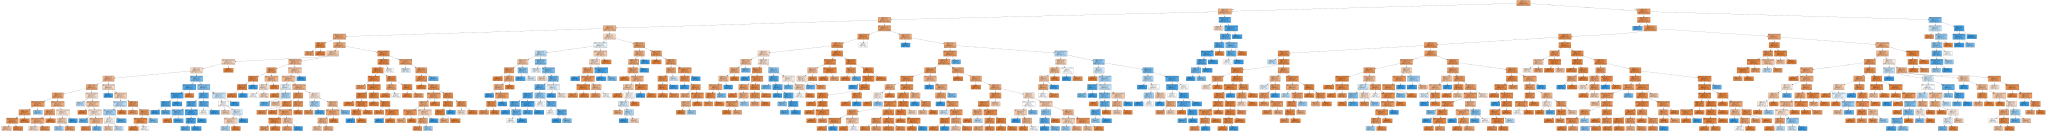

In [115]:
from sklearn.tree import export_graphviz
import graphviz

data = export_graphviz(best_tree.best_estimator_.estimators_[99], filled=True)
graphviz.Source(data)

Проверим, какие признаки были наиболее важными

In [112]:
best_tree.best_estimator_.feature_importances_

array([0.27680869, 0.01628171, 0.10512556, 0.06012279, 0.13338261,
       0.19085984, 0.01195296, 0.05097721, 0.10576797, 0.0107383 ,
       0.02912801, 0.00885434])

In [114]:
init_df = pd.concat([out, dummies], axis=1)
init_df.head()

,Age,Gender,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,42,0,619,2,0.00,1,1,1,101348.88,1,0,0
1,41,0,608,1,83807.86,1,0,1,112542.58,0,0,1
2,42,0,502,8,159660.80,3,1,0,113931.57,1,0,0
3,39,0,699,1,0.00,2,0,0,93826.63,1,0,0
4,43,0,850,2,125510.82,1,1,1,79084.10,0,0,1


In [127]:
features = init_df.columns
feat_importance = dict(zip(features, best_tree.best_estimator_.feature_importances_))
feat_importance = pd.DataFrame.from_dict(feat_importance, orient='index',
                                         columns=['Importance'])
feat_importance.sort_values(by='Importance', ascending=False)

,Importance
Age,0.276809
NumOfProducts,0.190860
Balance,0.133383
EstimatedSalary,0.105768
CreditScore,0.105126
Tenure,0.060123
IsActiveMember,0.050977
Geography_Germany,0.029128
Gender,0.016282
HasCrCard,0.011953
